### Leaky Integrate-and-Fire model

In [19]:
from math import exp
from matplotlib import pyplot as plt
from matplotlib.pyplot import *
from numpy import sin
import numpy as np
import pandas as pd
import random as rand

### LIF:

  We have a constant flow for a period of time, and during that time we use the following formula to implement               the model:

              τ .(du/dt) = -(U(t) - U_rest) + R.I_const(t)
              if u(t) => Threshold  then  Fire + Reset ( u = u reset )

In [20]:
class LIF:
    def __init__(self,dt=0.03125, tau=8, theta=-45, R=10,
                 U_rest=-79, U_reset=-65, U_spike=5, ref_time=0, ref_period=0):
        self.dt = dt
        self.tau = tau
        self.theta = theta
        self.R = R / 1000
        self.U_rest = U_rest
        self.U_reset = U_reset
        self.U_spike = U_spike
        self.ref_time = ref_time
        self.ref_period = ref_period
        self.U = self.U_rest
        self.last_fired = False

    ##   τ .(du/dt) = -(U(t) - U_rest) + R.I_const(t) -->
    ## du = (( -(U(t) - U_rest) + R.I_const(t) ) * dt ) / τ
    def du(self, I):
        self.U += (-(self.U - self.U_rest) + self.R * I) * self.dt / self.tau

    def firing(self):
        self.last_fired = True
        self.ref_time = self.ref_period
        self.U = self.U_spike

    def simulating(self, I):
        self.du(I)
        self.ref_time = max(self.ref_time - self.dt, 0)

        if self.last_fired or self.ref_time != 0:
            self.last_fired = False
            self.U = self.U_reset
            return self.U, I

        if self.U >= self.theta:
            self.firing()

        return self.U, I

### ELIF(In addition to exercise):

In [21]:
class ELIF(LIF):
    def __init__(self,theta_rh=-58, delta_t=1, *args,**kwargs):
        super(ELIF, self).__init__(*args, **kwargs)
        self.theta_rh = theta_rh
        self.delta_t = delta_t

    def du(self, I):
        self.U += (-(self.U - self.U_rest) + self.delta_t
                   * (exp((self.U - self.theta_rh) / self.delta_t)) + self.R * I)\
                   * self.dt / self.tau

### ALIF:

In [22]:
class ALIF(ELIF):
    def __init__(self,a=0.01,b=500,tau_k=100,*args, **kwargs):
        super(ALIF, self).__init__(*args, **kwargs)
        self.a = a * 32.25
        self.b = b * 32.25
        self.tau_k = tau_k
        self.w_k = 0

    def du(self, I):
        def dirac(): return int(self.last_fired)
        recent_u = self.U

        self.U += ((-(self.U - self.U_rest) ) + self.R * I ) * self.dt / self.tau

        if self.last_fired:
            self.w_k += (self.a * (recent_u - self.U_rest) - self.w_k + self.tau_k * self.b) * self.dt / self.tau_k
        else:
            self.w_k += (self.a * (recent_u - self.U_rest) - self.w_k) * self.dt / self.tau_k

### AELIF:

In [23]:
class AELIF(ELIF):
    def __init__(self, a=0.01, b=500, tau_k=100, *args, **kwargs):
        super(AELIF, self).__init__(*args, **kwargs)
        self.a = a * 32.25
        self.b = b * 32.25
        self.tau_k = tau_k
        self.w_k = 0

    def du(self, I):
        def dirac(): return int(self.last_fired)
        old_u = self.U

        self.U += (-(self.U - self.U_rest) + self.delta_t * (exp((self.U - self.theta_rh) / self.delta_t)) + self.R * I - (self.R * self.w_k)) * self.dt / self.tau

        if self.last_fired:
            self.w_k += (self.a * (old_u - self.U_rest) - self.w_k + self.tau_k * self.b) * self.dt / self.tau_k
        else:
            self.w_k += (self.a * (old_u - self.U_rest) - self.w_k) * self.dt / self.tau_k

### PLOT:

In [24]:

def plot_V_T(mv, time_list, name=1, top=None, bottom=None):
    plt.plot(time_list, mv)
    plt.ylim(top=top, bottom=bottom)
    plt.ylabel('Membrane Potential (mV)')
    plt.xlabel('Time (ms)')
    if name!=1: name=" for "+ name
    name="Voltage-Current"+name
    plt.title(name)
    plt.show()


def plot_I(current, time_list, name=1):
    plt.plot(time_list, current)
    plt.ylabel('Input current (pA)')
    plt.xlabel('Time (ms)')
    if name!=1: name=" for "+ name
    name="Time-Current"+ name
    plt.title(name)
    plt.show()


def plot_current(current, time_list, name=1):
    plt.plot(time_list, current)
    plt.ylabel('Adaption current (pA)')
    plt.xlabel('Time (ms)')
    if name!=1: name=" for "+name
    name="Time-Adaption Current"+name
    plt.title(name)
    plt.show()


def freq_vs_I_current(type, *args, **kwargs):
    current_list = [i for i in range(1000, 8000, 50)]
    freq_list = []
    for const_I in current_list:
        print("checking with current="+str(const_I))
        U_over_t, _, current = simulate_with_func(
            type, 10000, lambda x: const_I, *args, **kwargs)
        freq_list.append(len([0 for a in U_over_t if a > 0]) / 10000.0)

    plt.plot(current_list, freq_list)
    plt.ylabel('Frequency (KHz)')
    plt.xlabel('Input Current')
    plt.show()
    

def simulate_with_func(n_type, run_time, curr_func, dt, n_config, *args, **kwargs):
    neuron = eval('n_type(dt=dt,' +n_config+ ', *args, **kwargs)')
    U_over_t = []
    inter_curr = []
    current = [curr_func(t*neuron.dt) for t in range(int(run_time//neuron.dt))]
    for i in current:
        u, w_k = neuron.simulate_one_step(i)
        U_over_t.append(u)
        inter_curr.append(w_k)
    return U_over_t, inter_curr, current





def rand_array(l):
    from numpy import random, array, convolve, ones, linspace
    x=linspace(0, 1000, num=l*10)
    y = 0
    result = []
    for _ in x:
        result.append(y)
        y += random.normal(scale=1)
    r_x=10
    random_array=convolve(array(result), ones((r_x,)) / r_x)[(r_x - 1):]
    return lambda x: abs(random_array[int(x*10)])*200

total_time_frame = 100
dt = 0.03125
time_steps = int(total_time_frame // dt)

time_list = [i * dt for i in range(time_steps)]  # Total Time Frame / dt

constant_current = lambda x: int(10 <= x) * 3000
random_current = rand_array(time_steps)  # Total Time Frame / dt
step_func = lambda x: (int(10 <= x <= 20) * 2000 + int(30 <= x <= 40) * 5000 + int(50 <= x <= 60) * 7000)
sin_I_wave = lambda x: 4000 * (sin(x) + 0.9)
fifth_func = lambda x:( 2500 - (50 - x) ** (2) ) * 3




### PLOTING:

### LIF PLOT:

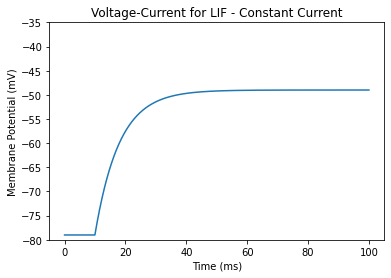

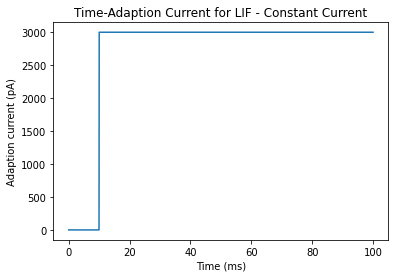

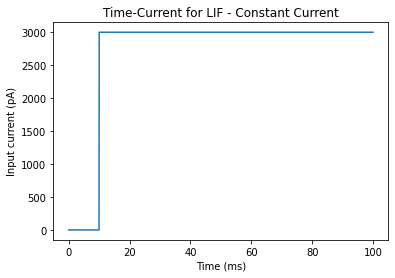

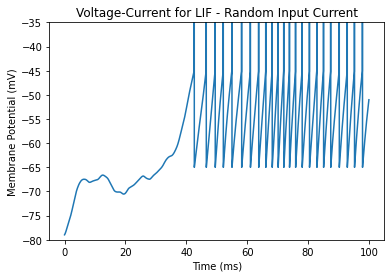

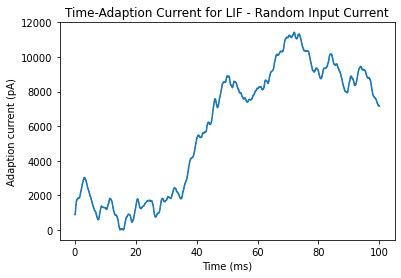

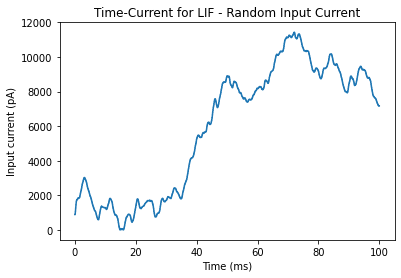

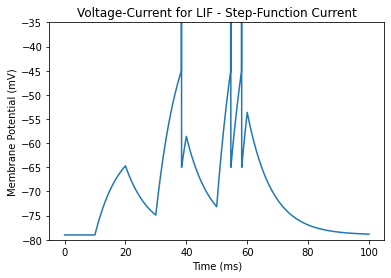

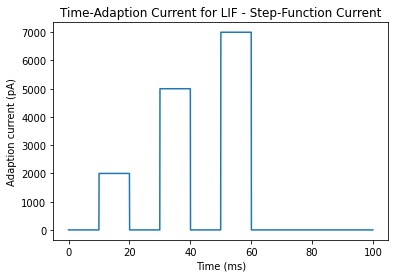

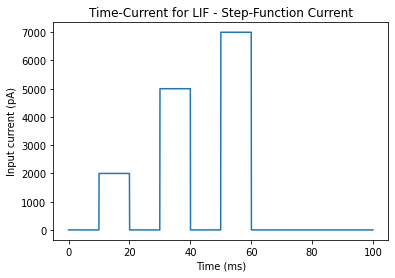

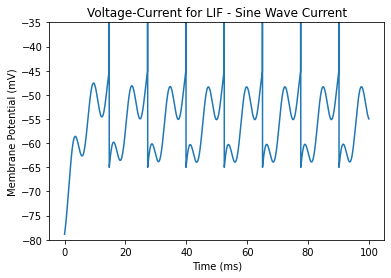

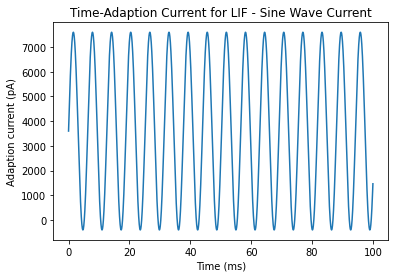

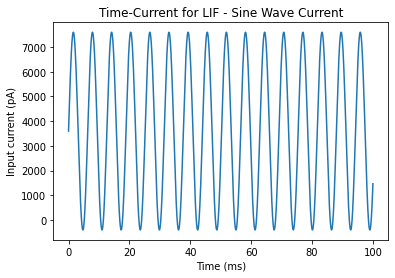

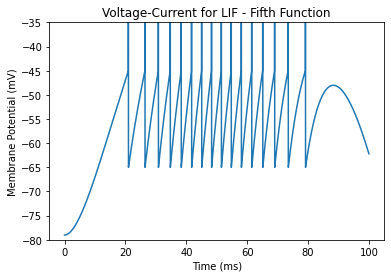

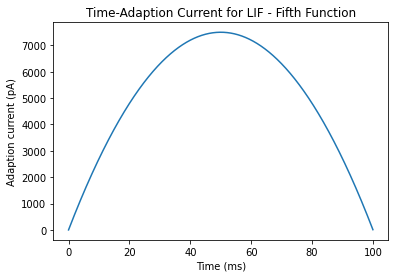

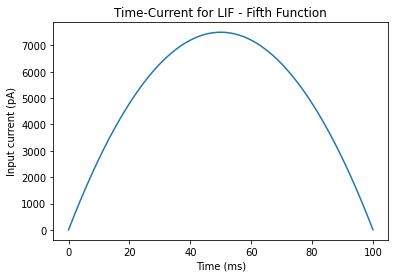

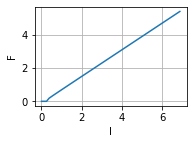

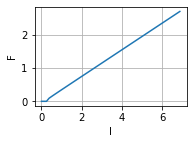

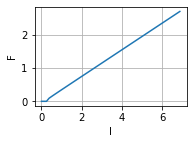

In [25]:
##neuron --> n

n = LIF()
u_time_plot = []
inter_curr = []
current = [constant_current(t * n.dt) for t in range(time_steps)]
for i in current:
    u, w_k = n.simulating(i)
    u_time_plot.append(u)
    inter_curr.append(w_k)

title = "LIF - Constant Current"
plot_V_T(u_time_plot, time_list, name=title, top=-35, bottom=-80)
plot_current(inter_curr, time_list, name=title)
plot_I(current, time_list, name=title)


## Random Input
n = LIF()
u_time_plot = []
inter_curr = []
current = [random_current(t * n.dt) for t in range(time_steps)]
for i in current:
    u, w_k = n.simulating(i)
    u_time_plot.append(u)
    inter_curr.append(w_k)

title = "LIF - Random Input Current"
plot_V_T(u_time_plot, time_list, name=title, top=-35, bottom=-80)
plot_current(inter_curr, time_list, name=title)
plot_I(current, time_list, name=title)


## Step-Function Current
n = LIF()
u_time_plot = []
inter_curr = []
current = [step_func(t * n.dt) for t in range(time_steps)]
for i in current:
    u, w_k = n.simulating(i)
    u_time_plot.append(u)
    inter_curr.append(w_k)

title = "LIF - Step-Function Current"
plot_V_T(u_time_plot, time_list, name=title, top=-35, bottom=-80)
plot_current(inter_curr, time_list, name=title)
plot_I(current, time_list, name=title)


## sin wave I
n = LIF()
u_time_plot = []
inter_curr = []
current = [sin_I_wave(t * n.dt) for t in range(time_steps)]
for i in current:
    u, w_k = n.simulating(i)
    u_time_plot.append(u)
    inter_curr.append(w_k)

title = "LIF - Sine Wave Current"
plot_V_T(u_time_plot, time_list, name=title, top=-35, bottom=-80)
plot_current(inter_curr, time_list, name=title)
plot_I(current, time_list, name=title)


## Fifth Func
n = LIF()
u_time_plot = []
inter_curr = []
current = [fifth_func(t * n.dt) for t in range(time_steps)]
for i in current:
    u, w_k = n.simulating(i)
    u_time_plot.append(u)
    inter_curr.append(w_k)

title = "LIF - Fifth Function"
plot_V_T(u_time_plot, time_list, name=title, top=-35, bottom=-80)
plot_current(inter_curr, time_list, name=title)
plot_I(current, time_list, name=title)

def i_interval(x, i):
    if 20 < x < 70:
        return i
    return 0

import random
def i_random(x, i):
    return random.random() * i


def lif(time=100, steps=0.125, i_function=i_interval, u_rest=0, r=1, c=10, i=5, threshold=2, f_i_plot=False,
        save_name="none"):
    timer = np.arange(0, time + steps, steps)
    tm = r * c
    u = [u_rest] * len(timer)
    dt = steps
    i_input = [i_function(j, i) for j in timer]

    # LIF Model -> NEURONAL DYNAMICS [Wulfram_Gerstner,_Werner_M_Kistle] page 11
    for j in range(len(timer)):
        u[j] = u[j - 1] + (-u[j - 1] + r * i_input[j]) / tm * dt
        if u[j] >= threshold or u[j] < u_rest:
            u[j] = u_rest

    # plotting
  
    if f_i_plot:
        i_x = np.arange(0, 7, 0.125)
        i_y = [0] * len(i_x)
        for j in range(len(i_x)):
            try:
                i_y[j] = 1 / (-1 * tm * (math.log(1 - (threshold - u_rest) / (r * j))))
            except:
                i_y[j] = 0
        subplot(222)
        plot(i_x, i_y)
        ylabel('F')
        xlabel('I')
        #title('F-I plot')
        grid(True)
    
    show()


lif(u_rest=0, r=1, c=5, i=5, threshold=2, f_i_plot=True)
lif(u_rest=0, r=1, c=10, i=5, threshold=2, f_i_plot=True)
lif(u_rest=0, r=1, c=10, i=5, threshold=2, f_i_plot=True, save_name="LIF1")

lif(u_rest=0, r=1, c=10, i=5, threshold=2, i_function=i_random, save_name="LIF_random1")
lif(u_rest=2, r=10, c=5, i=2, threshold=5, i_function=i_random, save_name="LIF_random2")
lif(u_rest=2, r=5, c=7, i=1, threshold=5, i_function=i_random, save_name="LIF_random3")
lif(u_rest=0, r=3, c=3, i=10, threshold=2, i_function=i_random, save_name="LIF_random4")
lif(u_rest=1, r=2, c=4, i=7, threshold=50, i_function=i_random, save_name="LIF_random5")


### ALIF PLOT:

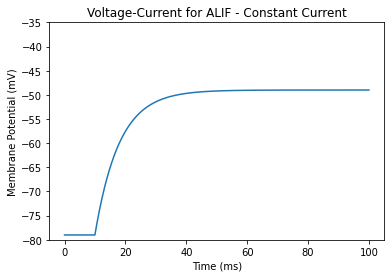

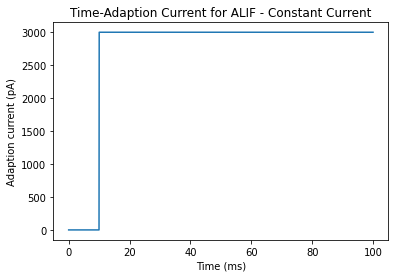

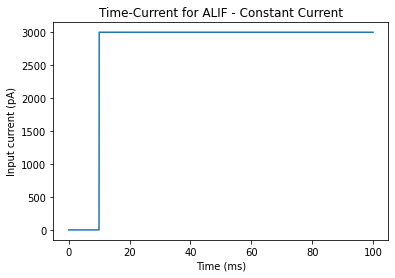

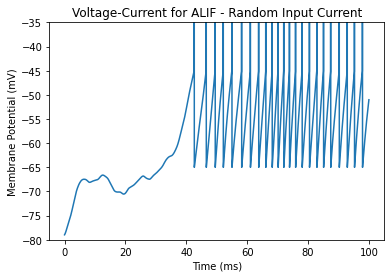

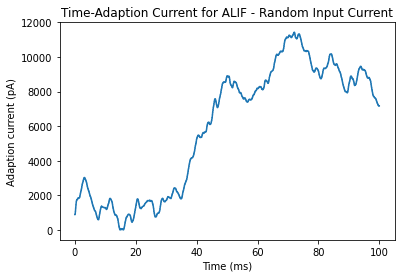

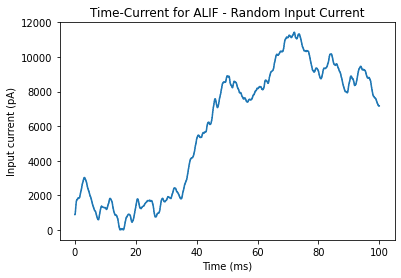

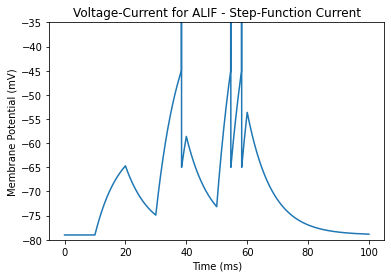

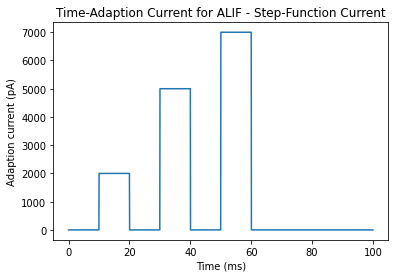

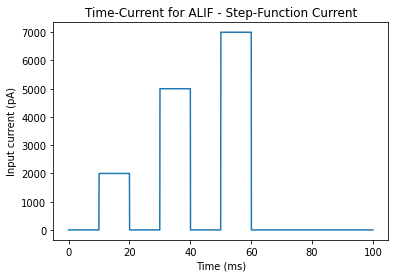

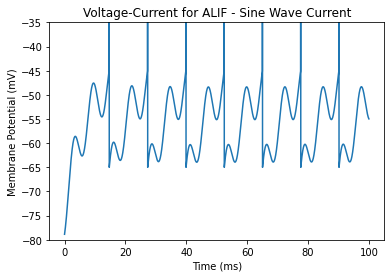

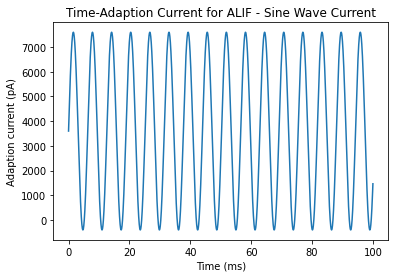

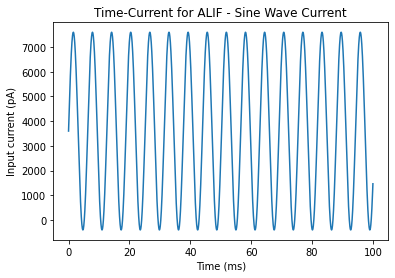

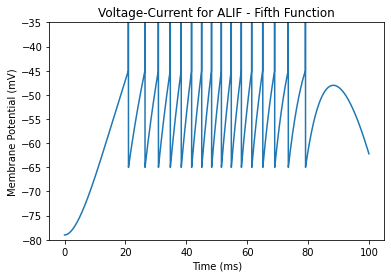

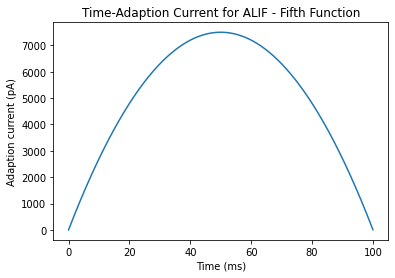

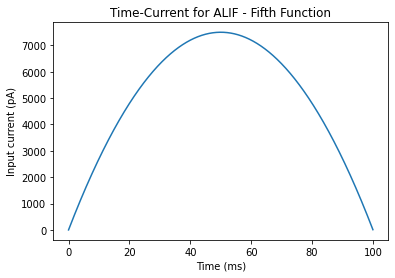

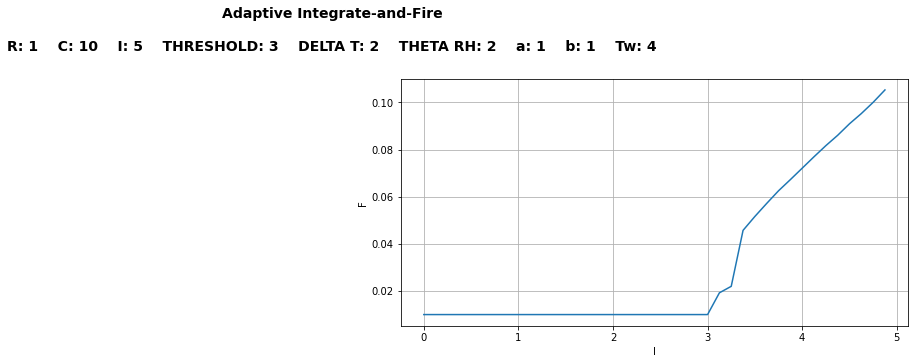

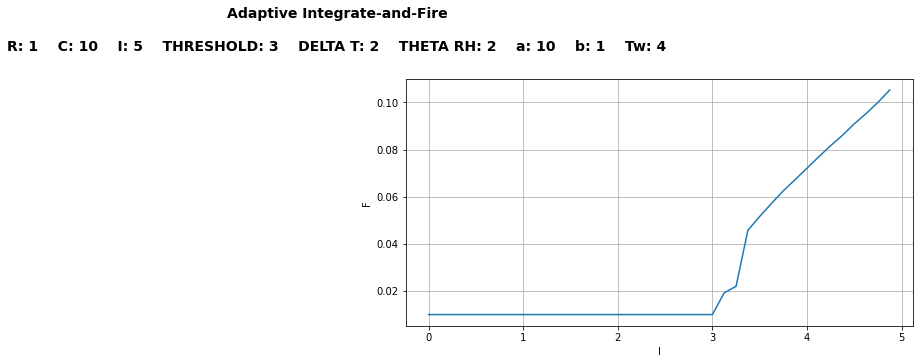

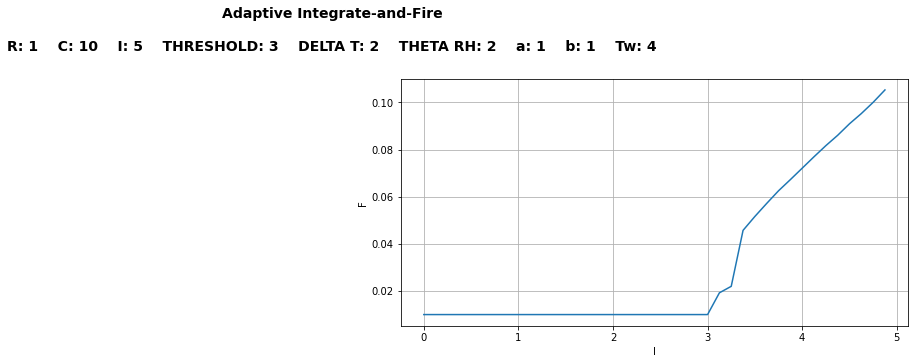

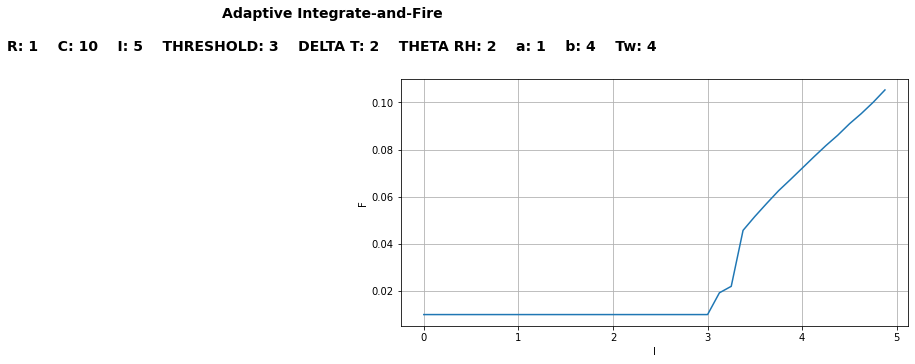

9.125

In [26]:

## Constant Current
n = ALIF()
u_time_plot = []
inter_curr = []
current = [constant_current(t * n.dt) for t in range(time_steps)]
for i in current:
    u, w_k = n.simulating(i)
    u_time_plot.append(u)
    inter_curr.append(w_k)

title = "ALIF - Constant Current"
plot_V_T(u_time_plot, time_list, name=title, top=-35, bottom=-80)
plot_current(inter_curr, time_list, name=title)
plot_I(current, time_list, name=title)

##------------------------------------------------------------------------##

## Random Input Current
n = ALIF()
u_time_plot = []
inter_curr = []
current = [random_current(t * n.dt) for t in range(time_steps)]
for i in current:
    u, w_k = n.simulating(i)
    u_time_plot.append(u)
    inter_curr.append(w_k)

title = "ALIF - Random Input Current"
plot_V_T(u_time_plot, time_list, name=title, top=-35, bottom=-80)
plot_current(inter_curr, time_list, name=title)
plot_I(current, time_list, name=title)

##-----------------------------------------------------------------##

## Step-Function Current
n = ALIF()
u_time_plot = []
inter_curr = []
current = [step_func(t * n.dt) for t in range(time_steps)]
for i in current:
    u, w_k = n.simulating(i)
    u_time_plot.append(u)
    inter_curr.append(w_k)

title = "ALIF - Step-Function Current"
plot_V_T(u_time_plot, time_list, name=title, top=-35, bottom=-80)
plot_current(inter_curr, time_list, name=title)
plot_I(current, time_list, name=title)


##-----------------------------------------------------------------------##

## SiN WAVE 
n = ALIF()
u_time_plot = []
inter_curr = []
current = [sin_I_wave(t * n.dt) for t in range(time_steps)]
for i in current:
    u, w_k = n.simulating(i)
    u_time_plot.append(u)
    inter_curr.append(w_k)

title = "ALIF - Sine Wave Current"
plot_V_T(u_time_plot, time_list, name=title, top=-35, bottom=-80)
plot_current(inter_curr, time_list, name=title)
plot_I(current, time_list, name=title)


##------------------------------------------------------------------------##

import math
## Fifth Function
n = ALIF()
u_time_plot = []
inter_curr = []
current = [fifth_func(t * n.dt) for t in range(time_steps)]
for i in current:
    u, w_k = n.simulating(i)
    u_time_plot.append(u)
    inter_curr.append(w_k)

title = "ALIF - Fifth Function"
plot_V_T(u_time_plot, time_list, name=title, top=-35, bottom=-80)
plot_current(inter_curr, time_list, name=title)
plot_I(current, time_list, name=title)


import numpy as np
from matplotlib.pyplot import *
import random
import math



def i_interval(x, i):
    if 20 < x < 70:
        return i
    return 0


def i_random(x, i):
    return random.random() * i


def AdEx(time=100, steps=0.125, i_function=i_interval, u_rest=0, r=1, c=10, i=5, threshold=3, delta_t=2, theta_rh=2, a=2, b=2, tw=5,
         f_i_plot=False,
         save_name="none",
         draw_plot=True):
    timer = np.arange(0, time + steps, steps)
    tm = r * c
    u = [u_rest] * len(timer)
    w = [0] * len(timer)
    dt = steps
    i_input = [i_function(j, i) for j in timer]
    zigma_delta_funciton = 0

    spike_t = time
    current_spike_time = 0


    for j in range(len(timer)):
        u[j] = u[j - 1] + (-u[j - 1] + r * i_input[j]) / tm * dt
        w[j] = w[j - 1] + (a * u[j - 1] - w[j - 1] + b * tw * zigma_delta_funciton) / tw * dt
        if u[j] >= threshold or u[j] < u_rest:
            u[j] = u_rest
            zigma_delta_funciton += 1
            prev_spike_time = current_spike_time
            current_spike_time = timer[j]
            spike_t = min(spike_t, current_spike_time - prev_spike_time)

    # plotting
    if draw_plot:
        fig = figure(num=None, figsize=(20, 10))
        fig.suptitle('Adaptive Integrate-and-Fire\n\n' + "R: " + str(r) + "    C: " + str(c) + "    I: " + str(i)
                     + "    THRESHOLD: " + str(threshold) + "    DELTA T: " + str(delta_t)
                     + "    THETA RH: " + str(theta_rh) + "    a: " + str(a) + "    b: " + str(b) + "    Tw: " + str(tw),
                     fontsize=14, fontweight='bold')
    

        if f_i_plot:
            i_x = np.arange(0, 5, 0.125)
            i_y = [0] * len(i_x)
            for j in range(len(i_x)):
                try:
                    i_y[j] = 1 / AdEx(time=time, steps=steps, i_function=i_function, u_rest=u_rest, r=r, c=c, i=i_x[j], a=a, b=b, tw=tw,
                                      threshold=threshold, delta_t=delta_t, theta_rh=theta_rh, f_i_plot=False,
                                      save_name="none",
                                      draw_plot=False)
                except:
                    i_y[j] = 0
            subplot(222)
            plot(i_x, i_y)
            ylabel('F')
            xlabel('I')
            #title('F-I plot')
            grid(True)
    
        show()

    return spike_t


AdEx(a=1 , b=1 , tw=4, f_i_plot=True)
AdEx(a=10 , b=1 , tw=4, f_i_plot=True)
AdEx(a=1 , b=1 , tw=4, f_i_plot=True, save_name="AdEx1")
AdEx(a=1 , b=4 , tw=4, f_i_plot=True, save_name="AdEx2")



### ELIF PLOTING(In addition to exercise)

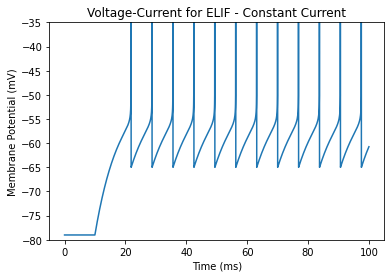

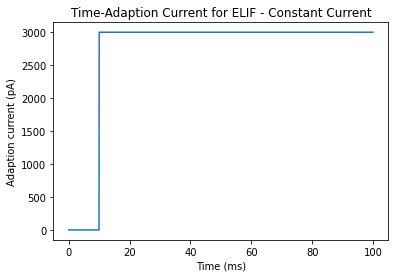

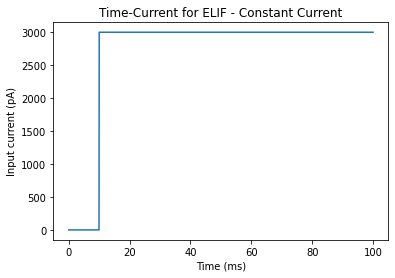

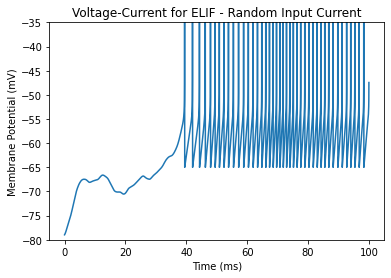

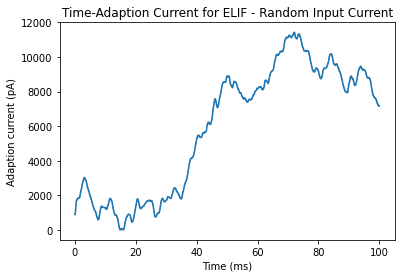

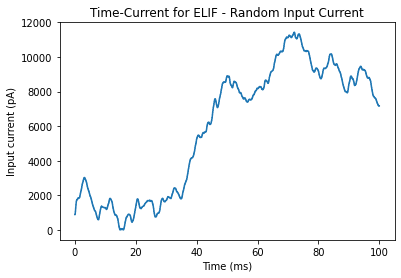

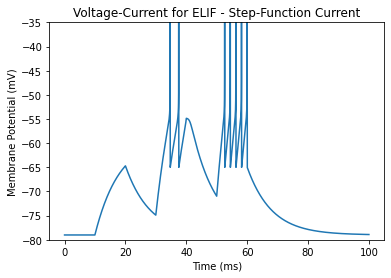

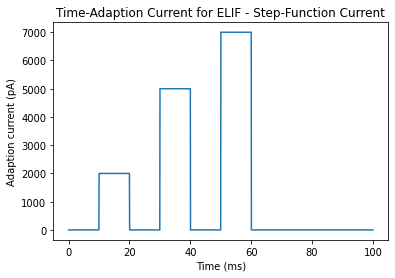

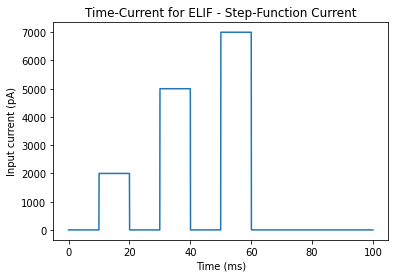

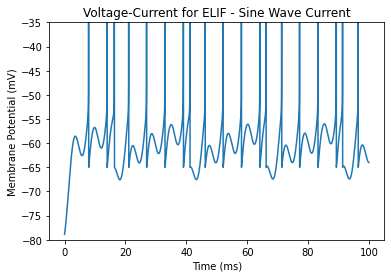

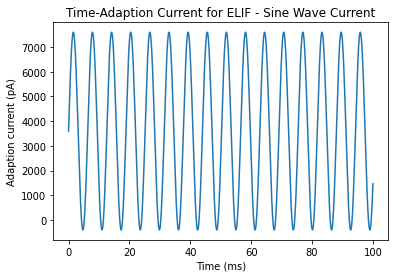

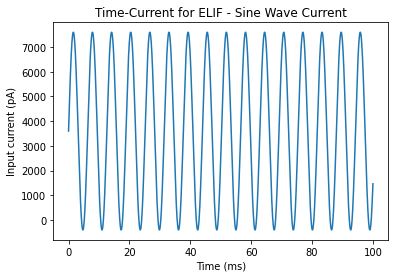

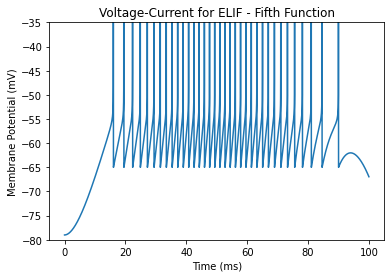

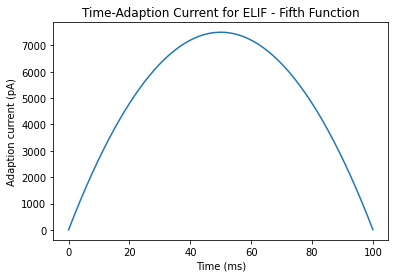

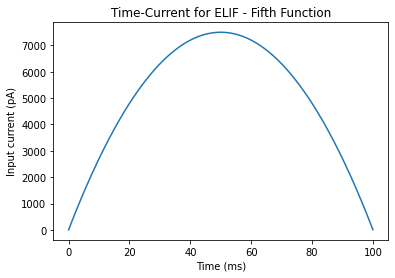

In [27]:
n = ELIF()
u_time_plot = []
inter_curr = []
current = [constant_current(t * n.dt) for t in range(time_steps)]
for i in current:
    u, w_k = n.simulating(i)
    u_time_plot.append(u)
    inter_curr.append(w_k)

title = "ELIF - Constant Current"
plot_V_T(u_time_plot, time_list, name=title, top=-35, bottom=-80)
plot_current(inter_curr, time_list, name=title)
plot_I(current, time_list, name=title)



## Random Input
n = ELIF()
u_time_plot = []
inter_curr = []
current = [random_current(t * n.dt) for t in range(time_steps)]
for i in current:
    u, w_k = n.simulating(i)
    u_time_plot.append(u)
    inter_curr.append(w_k)

title = "ELIF - Random Input Current"
plot_V_T(u_time_plot, time_list, name=title, top=-35, bottom=-80)
plot_current(inter_curr, time_list, name=title)
plot_I(current, time_list, name=title)


## Step-Func
n = ELIF()
u_time_plot = []
inter_curr = []
current = [step_func(t * n.dt) for t in range(time_steps)]
for i in current:
    u, w_k = n.simulating(i)
    u_time_plot.append(u)
    inter_curr.append(w_k)

title = "ELIF - Step-Function Current"
plot_V_T(u_time_plot, time_list, name=title, top=-35, bottom=-80)
plot_current(inter_curr, time_list, name=title)
plot_I(current, time_list, name=title)


## Sin wave
n = ELIF()
u_time_plot = []
inter_curr = []
current = [sin_I_wave(t * n.dt) for t in range(time_steps)]
for i in current:
    u, w_k = n.simulating(i)
    u_time_plot.append(u)
    inter_curr.append(w_k)

title = "ELIF - Sine Wave Current"
plot_V_T(u_time_plot, time_list, name=title, top=-35, bottom=-80)
plot_current(inter_curr, time_list, name=title)
plot_I(current, time_list, name=title)


## Fifth Func
n = ELIF()
u_time_plot = []
inter_curr = []
current = [fifth_func(t * n.dt) for t in range(time_steps)]
for i in current:
    u, w_k = n.simulating(i)
    u_time_plot.append(u)
    inter_curr.append(w_k)

title = "ELIF - Fifth Function"
plot_V_T(u_time_plot, time_list, name=title, top=-35, bottom=-80)
plot_current(inter_curr, time_list, name=title)
plot_I(current, time_list, name=title)

### AELIF PLOTING:

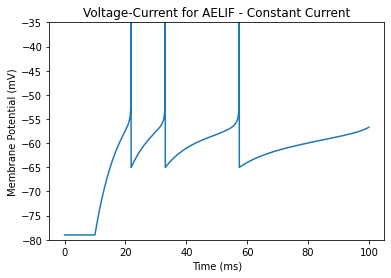

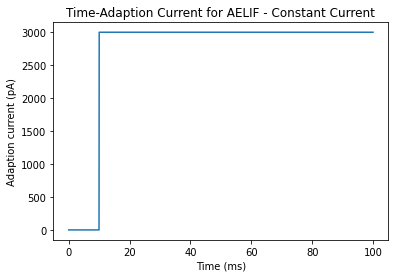

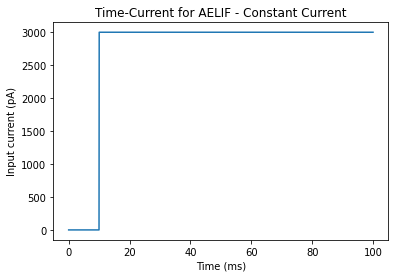

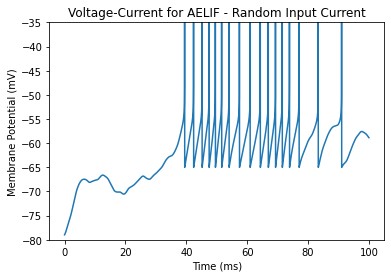

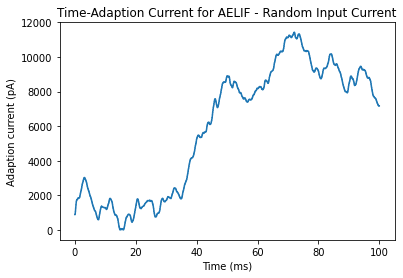

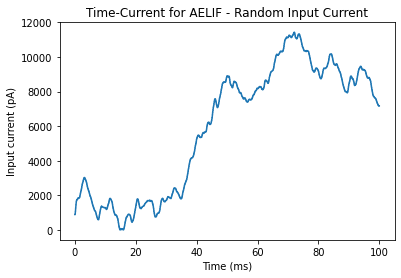

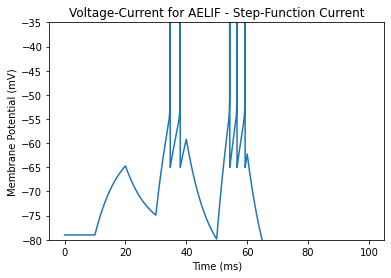

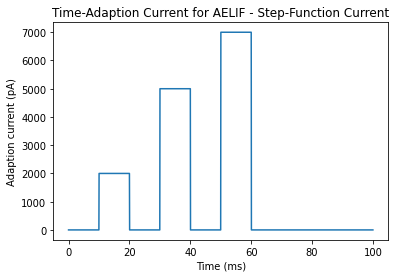

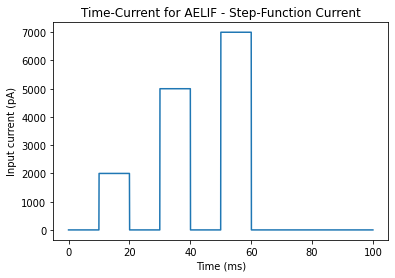

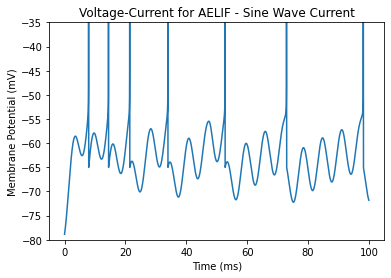

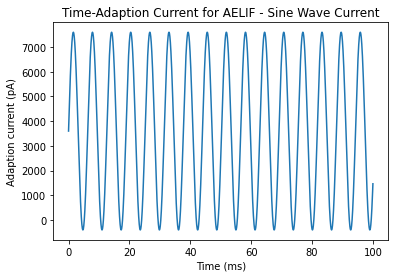

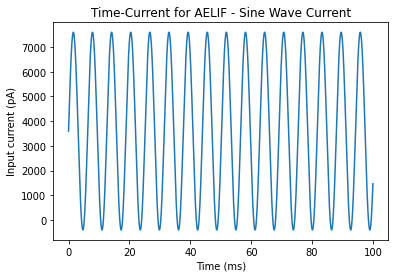

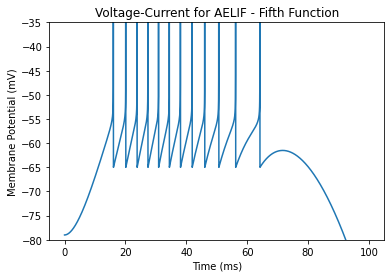

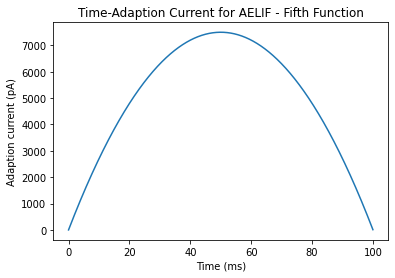

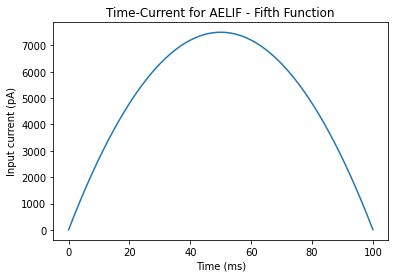

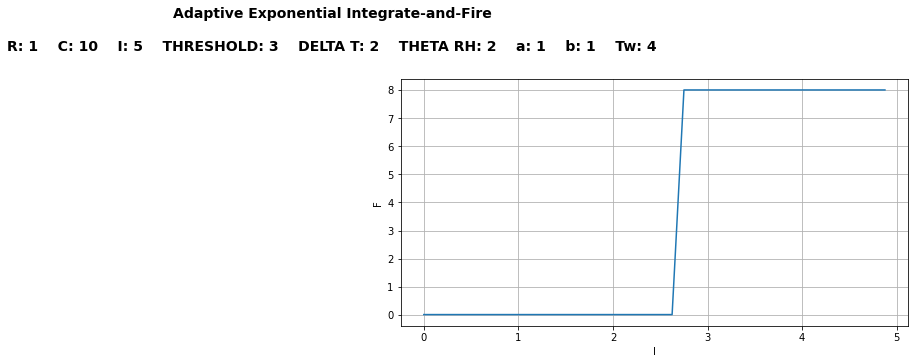

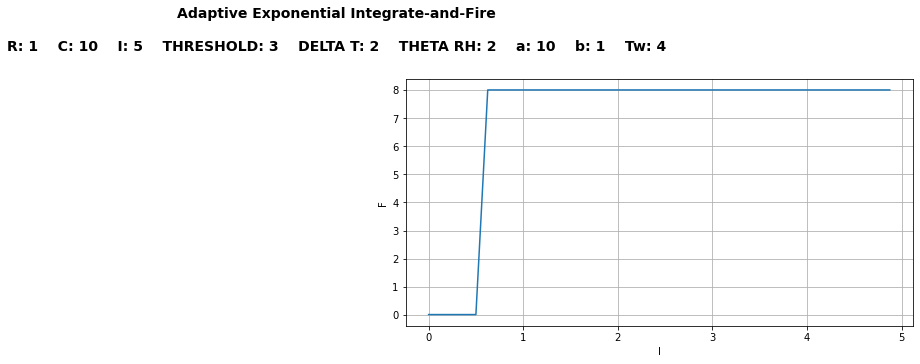

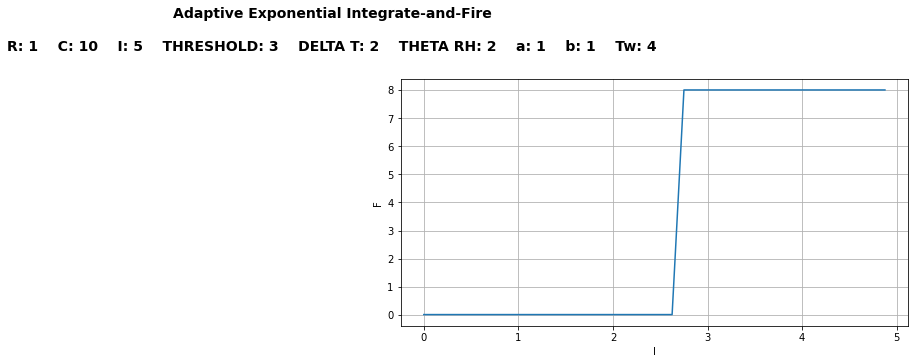

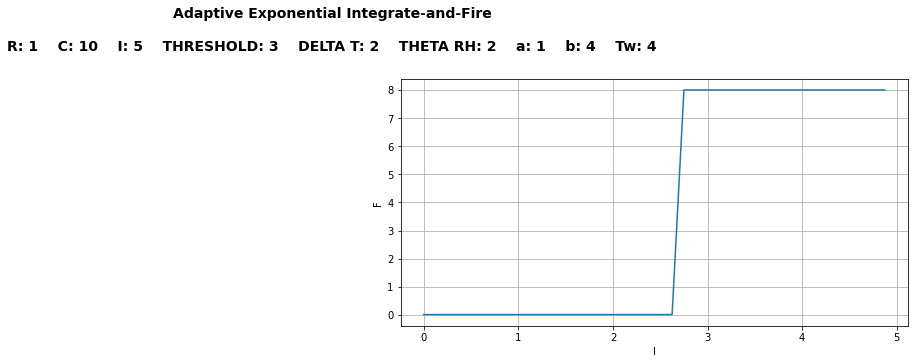

0.125

In [28]:
n = AELIF()
u_time_plot = []
inter_curr = []
current = [constant_current(t * n.dt) for t in range(time_steps)]
for i in current:
    u, w_k = n.simulating(i)
    u_time_plot.append(u)
    inter_curr.append(w_k)

title = "AELIF - Constant Current"
plot_V_T(u_time_plot, time_list, name=title, top=-35, bottom=-80)
plot_current(inter_curr, time_list, name=title)
plot_I(current, time_list, name=title)


## Random Input
n = AELIF()
u_time_plot = []
inter_curr = []
current = [random_current(t * n.dt) for t in range(time_steps)]
for i in current:
    u, w_k = n.simulating(i)
    u_time_plot.append(u)
    inter_curr.append(w_k)

title = "AELIF - Random Input Current"
plot_V_T(u_time_plot, time_list, name=title, top=-35, bottom=-80)
plot_current(inter_curr, time_list, name=title)
plot_I(current, time_list, name=title)


## Step-Func
n = AELIF()
u_time_plot = []
inter_curr = []
current = [step_func(t * n.dt) for t in range(time_steps)]
for i in current:
    u, w_k = n.simulating(i)
    u_time_plot.append(u)
    inter_curr.append(w_k)

title = "AELIF - Step-Function Current"
plot_V_T(u_time_plot, time_list, name=title, top=-35, bottom=-80)
plot_current(inter_curr, time_list, name=title)
plot_I(current, time_list, name=title)



## Sin WAVE
n = AELIF()
u_time_plot = []
inter_curr = []
current = [sin_I_wave(t * n.dt) for t in range(time_steps)]
for i in current:
    u, w_k = n.simulating(i)
    u_time_plot.append(u)
    inter_curr.append(w_k)

title = "AELIF - Sine Wave Current"
plot_V_T(u_time_plot, time_list, name=title, top=-35, bottom=-80)
plot_current(inter_curr, time_list, name=title)
plot_I(current, time_list, name=title)



## Fifth Func
n = AELIF()
u_time_plot = []
inter_curr = []
current = [fifth_func(t * n.dt) for t in range(time_steps)]
for i in current:
    u, w_k = n.simulating(i)
    u_time_plot.append(u)
    inter_curr.append(w_k)

title = "AELIF - Fifth Function"
plot_V_T(u_time_plot, time_list, name=title, top=-35, bottom=-80)
plot_current(inter_curr, time_list, name=title)
plot_I(current, time_list, name=title)




def i_interval(x, i):
    if 20 < x < 70:
        return i
    return 0


def i_random(x, i):
    return random.random() * i


def AdEx(time=100, steps=0.125, i_function=i_interval, u_rest=0, r=1, c=10, i=5, threshold=3, delta_t=2, theta_rh=2, a=2, b=2, tw=5,
         f_i_plot=False,
         save_name="none",
         draw_plot=True):
    timer = np.arange(0, time + steps, steps)
    tm = r * c
    u = [u_rest] * len(timer)
    w = [0] * len(timer)
    dt = steps
    i_input = [i_function(j, i) for j in timer]
    zigma_delta_funciton = 0

    spike_t = time
    current_spike_time = 0

    # AdEx LIF Model -> NEURONAL DYNAMICS [Wulfram_Gerstner,_Werner_M_Kistle] page 137
    for j in range(len(timer)):
        u[j] = u[j - 1] + (-u[j - 1] + r * i_input[j] + delta_t * math.exp((u[j - 1] - theta_rh) / delta_t) - r * w[j - 1]) / tm * dt
        w[j] = w[j - 1] + (a * u[j - 1] - w[j - 1] + b * tw * zigma_delta_funciton) / tw * dt
        if u[j] >= threshold or u[j] < u_rest:
            u[j] = u_rest
            zigma_delta_funciton += 1
            prev_spike_time = current_spike_time
            current_spike_time = timer[j]
            spike_t = min(spike_t, current_spike_time - prev_spike_time)

    # plotting
    if draw_plot:
        fig = figure(num=None, figsize=(20, 10))
        fig.suptitle('Adaptive Exponential Integrate-and-Fire\n\n' + "R: " + str(r) + "    C: " + str(c) + "    I: " + str(i)
                     + "    THRESHOLD: " + str(threshold) + "    DELTA T: " + str(delta_t)
                     + "    THETA RH: " + str(theta_rh) + "    a: " + str(a) + "    b: " + str(b) + "    Tw: " + str(tw),
                     fontsize=14, fontweight='bold')
    

        if f_i_plot:
            i_x = np.arange(0, 5, 0.125)
            i_y = [0] * len(i_x)
            for j in range(len(i_x)):
                try:
                    i_y[j] = 1 / AdEx(time=time, steps=steps, i_function=i_function, u_rest=u_rest, r=r, c=c, i=i_x[j], a=a, b=b, tw=tw,
                                      threshold=threshold, delta_t=delta_t, theta_rh=theta_rh, f_i_plot=False,
                                      save_name="none",
                                      draw_plot=False)
                except:
                    i_y[j] = 0
            subplot(222)
            plot(i_x, i_y)
            ylabel('F')
            xlabel('I')
            #title('F-I plot')
            grid(True)
    
        show()

    return spike_t


AdEx(a=1 , b=1 , tw=4, f_i_plot=True)
AdEx(a=10 , b=1 , tw=4, f_i_plot=True)
AdEx(a=1 , b=1 , tw=4, f_i_plot=True, save_name="AdEx1")
AdEx(a=1 , b=4 , tw=4, f_i_plot=True, save_name="AdEx2")

